In [41]:
import pandas as pd
import numpy as np
import json
import os
from multiprocessing import Pool
from tqdm.notebook import tqdm
import gc
import pickle
import joblib
import cv2
#import bz2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import config


In [104]:
class Config(object):
    DATA_PATH = 'data/imaterialist-fashion-2020-fgvc7'
    IMAGE_SIZE = 256
    NO_OF_CLASSES = 46
    BATCH_SIZE = 8
    OUTPUT_MASK_SIZE=256
    RESIZE=True
    
        

In [143]:
class Dataset():
    def __init__ (self, config, df, random_seed=0):
        self.CONFIG = config
        self.TRAINING_DATA_PATH = self.CONFIG.DATA_PATH + '/train/'
        self.TRAINING_DATA_FRAME = df
        self.DATASET_IDXS = self.TRAINING_DATA_FRAME.ImageId.unique()
        self.DATASET_SIZE = self.DATASET_IDXS.shape[0]
        
        np.random.seed(random_seed)
        np.random.shuffle(self.DATASET_IDXS)
        self.CURRENT_IDX=0
        
    def get_image(self, image_id, resize=True):
        img = cv2.cvtColor( cv2.imread(self.TRAINING_DATA_PATH+image_id+'.jpg'), cv2.COLOR_BGR2RGB)
        if resize:
            return cv2.resize(img, 
                              (self.CONFIG.IMAGE_SIZE, self.CONFIG.IMAGE_SIZE), 
                              interpolation = cv2.INTER_NEAREST)
        else:
            return img
        
    def make_single_mask(self, encoded_string, height, width):
        splitted_string = np.array(list(map(int, encoded_string.split()))).reshape(-1,2)
        mask = np.zeros((height*width), dtype=np.uint8)
        for start_indice, run_length in splitted_string:
            start_indice-=1
            mask[start_indice:start_indice+run_length] = 1
        return mask.reshape((height, width), order='F')
    
    def get_mask(self, image_id, resize=True):
        query = self.TRAINING_DATA_FRAME[self.TRAINING_DATA_FRAME.ImageId==image_id]
        encoded_pixels = query.EncodedPixels
        class_ids = query.ClassId
        height, width = list(query.Height)[0], list(query.Width)[0]
        
        if resize:
            mask = np.zeros((self.CONFIG.OUTPUT_MASK_SIZE, self.CONFIG.OUTPUT_MASK_SIZE, self.CONFIG.NO_OF_CLASSES), 
                            dtype=np.uint8)
        else:
            mask = np.zeros((height, width, self.CONFIG.NO_OF_CLASSES), 
                            dtype=np.uint8)
            
        for _, (encoded_pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            sub_mask = self.make_single_mask(encoded_pixel_str, height, width)
            if resize:
                sub_mask = cv2.resize(sub_mask, 
                                      (self.CONFIG.OUTPUT_MASK_SIZE, self.CONFIG.OUTPUT_MASK_SIZE), 
                                      interpolation=cv2.INTER_NEAREST)
            mask[:,:,class_id] = sub_mask
        return mask                    
    
    def sample_next_batch(self):
        next_idx = self.CURRENT_IDX+self.CONFIG.BATCH_SIZE
        if next_idx>self.DATASET_SIZE-1:
            next_idx = self.CONFIG.BATCH_SIZE-(self.DATASET_SIZE-self.CURRENT_IDX)
            batch_idxs = np.concatenate((self.DATASET_IDXS[self.CURRENT_IDX:], 
                                        self.DATASET_IDXS[:next_idx]))
            self.CURRENT_IDX = next_idx
            return batch_idxs, True
        else:
            batch_idxs = self.DATASET_IDXS[self.CURRENT_IDX:next_idx]
            self.CURRENT_IDX = next_idx
            return batch_idxs, False
    
    def get_next_batch(self, resize=True):
        batch_idxs, epoch_finish = self.sample_next_batch()
        print(batch_idxs)
        train_item, test_item = [], []
        for image_id in batch_idxs:
            train_item.append(self.get_image(image_id, resize=resize))
            test_item.append(self.get_mask(image_id, resize=resize))
        return np.array(train_item), np.array(test_item), epoch_finish
            
        
        

# Model

In [153]:
import torchvision

In [156]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [158]:
from PIL import Image

In [182]:
len(COCO_INSTANCE_CATEGORY_NAMES)

91

In [159]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class


In [173]:
from torchvision import transforms as T
a,b,c = get_prediction(config.DATA_PATH+'/train/'+train_df[train_df.columns[0]][0]+'.jpg', .5)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [179]:
c

['person', 'tie', 'tie']

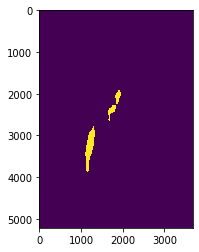

In [181]:
plt.imshow(a[2])

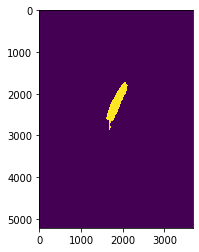

In [180]:
plt.imshow(a[1])

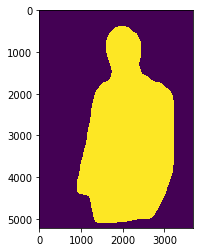

In [178]:
plt.imshow(a[0])

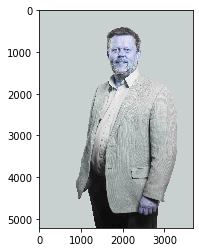

In [176]:
plt.imshow(cv2.imread(config.DATA_PATH+'/train/'+train_df[train_df.columns[0]][0]+'.jpg'))

# Main

In [177]:
config = Config()
train_df = pd.read_csv(config.DATA_PATH+'/train.csv')

In [144]:
d = Dataset(config, train_df)

In [150]:
a, b, c = d.get_next_batch(resize=False)

['0cc89a84a6beab91f27e74085efa2d26' 'f241d5d9463a04b5b7fb4f87f38dec19'
 '4103ae509d6d30c5c866f98c602236d4' 'c04a4c717db7bf85b66815658ec4dabb'
 'ffe31be462c0f3fa586171f7df788887' 'c6e7163adcb5992f36d7527ae241690d'
 '22722cf5130f94811e8bfd189c435e87' '7e7d2de5af00efbd7aa00760c5369ddf']


In [184]:
train_df[train_df.columns[1]][0]

'6068157 7 6073371 20 6078584 34 6083797 48 6089010 62 6094223 72 6099436 76 6104649 80 6109862 85 6115075 89 6120288 93 6125501 98 6130714 102 6135927 106 6141140 111 6146354 114 6151567 118 6156780 123 6161993 127 6167206 131 6172419 136 6177632 140 6182845 144 6188058 149 6193271 153 6198484 157 6203697 162 6208910 166 6214124 169 6219337 174 6224550 178 6229763 182 6234976 187 6240189 191 6245402 195 6250615 200 6255828 204 6261041 208 6266254 213 6271467 218 6276680 224 6281893 229 6287107 233 6292320 238 6297533 244 6302746 249 6307959 254 6313172 259 6318385 265 6323598 270 6328811 275 6334024 280 6339237 286 6344450 291 6349663 296 6354877 300 6360090 306 6365303 311 6370516 316 6375729 322 6380942 327 6386155 332 6391368 337 6396581 343 6401794 348 6407007 353 6412220 358 6417433 364 6422647 368 6427860 373 6433073 378 6438286 384 6443499 389 6448712 394 6453925 399 6459138 405 6464351 410 6469564 415 6474777 420 6479990 426 6485203 431 6490416 436 6495630 441 6500843 446 6506